# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas
import numpy as np
import json

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

X.columns

Index(['Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Name__other',
       'Type 1__other', 'Type 2__other', 'HP__other', 'Attack__other',
       'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other',
       'Generation__other', 'Legendary__other'],
      dtype='object')

In [2]:
# Get the list of opposite lables with the current ones
def add_opposite_labels(labels):
    rt = list(labels)
    for l in labels:
        rt.append(opposite_label(l))
    return rt

# Get the list of opposite lables
def get_opposite_labels(labels):
    return [
        opposite_label(l)
        for l in labels
    ]

# Get current labels and opposite ones, to iterate them separetly
def double_opposite_labels(labels):
    return labels, get_opposite_labels(labels)

# Get Opposite of label
def opposite_label(label):
    other = '__other'
    if label.endswith(other):
        return label[:-len(other)]
    return f'{label}{other}'

# Remove prefix from string
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [3]:
X.dtypes

Name                  object
Type 1                object
Type 2                object
HP                   float64
Attack               float64
Defense              float64
Sp. Atk              float64
Sp. Def              float64
Speed                float64
Generation           float64
Legendary             object
Name__other           object
Type 1__other         object
Type 2__other         object
HP__other            float64
Attack__other        float64
Defense__other       float64
Sp. Atk__other       float64
Sp. Def__other       float64
Speed__other         float64
Generation__other    float64
Legendary__other      object
dtype: object

2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot: >

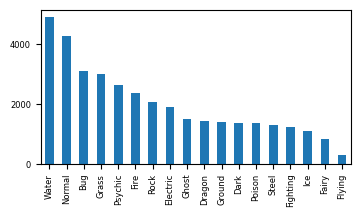

In [4]:
X['Type 1'].value_counts().plot(kind='bar', figsize=(4,2), fontsize=6)

3. Determine which of the features have missing values. How many missing values there are for each one?

In [5]:
X.isna().sum()
# About 4000 missing values per column
# But Type 2 has extra missing values because not every pokemon has Type 2 (same applies for the __other variable)

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

Total target
False    21152
True     18848
Name: Wins, dtype: int64

Percentage target
False    0.5288
True     0.4712
Name: Wins, dtype: float64


<AxesSubplot: >

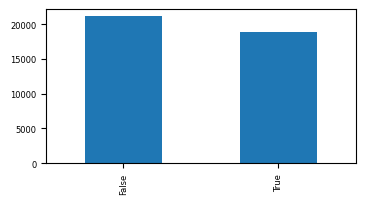

In [6]:
print('Total target')
print(y.value_counts())

print('')

print('Percentage target')
print(y.value_counts() / len(y))

y.value_counts().plot(kind='bar', figsize=(4,2), fontsize=6)
# Quite balanced, not perfect 50%, but a 3% deviation doesn't scream bias

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

In [7]:
# There is certain information that can be deduced directly from the 
# name of a Pokemon
# This information is:
# - The stats of the Pokemon if we know their level
#   (and we can deduce their level from their other stats)
# - Types of the Pokemon
# - Other data such as if the Pokemon is legendary, the generation etc.

In [8]:
# This allows us to predict aprox 90% of
# the missing information for the columns
# that can be deduced from the Pokemon's Name
class DeduceFeaturesFromNameTransformer:
    # We are going to the deduce
    # information about these attributes:
    deduce_from_name = ['Type 1', 'Legendary', 'Generation']
    def __init__(self):
        self.fitted_data = {}
    
    def fit(self, X, y=None):
        for col in self.deduce_from_name:
            self.fit_column(X, col)
        return self
    
    def fit_column(self, X, column):
        name_type = X[add_opposite_labels(['Name', column])].dropna()
        column_data = {}
        for n, t in double_opposite_labels(['Name', column]):
            column_data.update(dict(zip(name_type[n],name_type[t])))

        to_add = {}
        for k, v in column_data.items():
            k = remove_prefix(k, 'Mega ')
            if k not in column_data:
                to_add[k] = v
        column_data.update(to_add)
        self.fitted_data[column] = column_data

    def transform_column(self, X, column):
        for n, t in double_opposite_labels(['Name', column]):
            filler = X.apply(lambda row: self.fitted_data[column].get(row[n], None), axis=1)
            X[t] = X[t].fillna(filler)

    def transform(self, X, y=None):
        for col in self.deduce_from_name:
            self.transform_column(X, col)
        return X


In [9]:
# A lot of pokemons do NOT have Type 2, so those numbers are not representative
# We may miss some information otherwise, but we should not fill in random Type 2
# from pokemons around

# We don't want to fill with other imputters these values if they are None at this point

class FillEmptyNonPredictableTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in add_opposite_labels(['Name', 'Type 2', 'Type 1']):
            X[col] = X[col].fillna(value='')
        return X

In [10]:
# from sklearn.impute import SimpleImputer
predict_columns = [
    col
    for col in X.columns if '__other' not in col
    if col not in {'Name', 'Type 1', 'Type 2'}
]
name_predict_columns = ['Name'] + predict_columns

columns_other = {
    opposite_label(col): col for col in name_predict_columns
}
name_columns_other = get_opposite_labels(name_predict_columns)

# first_half = X[predict_columns]
# second_half = X[get_opposite_labels(predict_columns)]
# second_half = second_half.rename(columns=columns_other)
# unified_pokemons = pandas.concat([X[name_predict_columns], X[name_columns_other].rename(columns=columns_other)])

# named_pokemons = unified_pokemons[unified_pokemons['Name'].notna()]
# named_pokemons_nan = named_pokemons[named_pokemons.isna().any(axis=1)]

# from ipywidgets import IntProgress
# from IPython.display import display

# f = IntProgress(min=0, max=len(named_pokemons_nan.index))
# display(f)

# for index, row in named_pokemons_nan.iterrows():
#     f.value += 1
#     name = remove_prefix(row['Name'], 'Mega ')
#     train_iteration = unified_pokemons[unified_pokemons['Name'] == name]
#     train_iteration = train_iteration[train_iteration.isna().any(axis=1)]
#     number_train = len(train_iteration.index)
#     if number_train < 2:
#         continue
#     row.loc[predict_columns] = train_iteration[predict_columns].mean()
#     X.loc[index] = row



In [11]:
from sklearn.impute import KNNImputer

class KNNImputerBothSidesTransformer:
    def __init__(self):
        self.imputer = KNNImputer(n_neighbors=2, weights='distance')
    
    def get_halfs(self, X):
        first_half = X[predict_columns]
        second_half = X[get_opposite_labels(predict_columns)]
        second_half = second_half.rename(columns=columns_other)
        return first_half, second_half

    def fit(self, X, y=None):
        first_half, second_half = self.get_halfs(X)
        self.imputer.fit(pandas.concat([first_half, second_half]))
        return self
    
    def transform(self, X, y=None):
        first_half, second_half = self.get_halfs(X)
        first_half_predict = self.imputer.transform(first_half)
        second_half_predict = self.imputer.transform(second_half)
        X[predict_columns] = first_half_predict
        X[get_opposite_labels(predict_columns)] = second_half_predict
        return X

In [12]:
class AddPokemonRatiosTransformer:
    def __init__(self):
        with open('type-chart.json') as f:
            self.type_matrix = json.load(f)

    def map_row_attack_multipler(self, row, opposite):
        type_row = ['Type 1', 'Type 2']
        if opposite:
            type_row = get_opposite_labels(type_row)
        best_attack_multiplier = 0.25
        at_least_one_type = False
        for attack_type in type_row:
            attack_type = row[attack_type].lower()
            if not attack_type: continue
            multiplier = 1
            for defense_type in type_row:
                enemy_defense = defense_type if opposite else opposite_label(defense_type)
                defense_type = row[enemy_defense].lower()
                if not defense_type: continue
                multiplier *= self.type_matrix[attack_type][defense_type]
                at_least_one_type = True
            best_attack_multiplier = max(best_attack_multiplier, multiplier)
        if not at_least_one_type:
            return 1
        return best_attack_multiplier

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        clean_ratios = X[add_opposite_labels(['Attack', 'Defense', 'Sp. Atk', 'Sp. Def'])]
        clean_ratios = X.replace(0, 1)
        for side in [True, False]:
            ot_label = '', '__other'
            if not side:
                ot_label = ot_label[::-1]
            first_label, second_label = ot_label
            at_def_ratio = X[f'Attack{first_label}'] / clean_ratios[f'Defense{second_label}']
            sp_at_def_ratio = X[f'Sp. Atk{first_label}'] / clean_ratios[f'Sp. Def{second_label}']
            best_ratio = pandas.concat([at_def_ratio, sp_at_def_ratio], axis=1).max(axis=1)
            X[f'best_attack_ratio{first_label}'] = best_ratio

            
            X[f'is_mega{first_label}'] = X[f'Name{first_label}'].str.contains('Mega ', regex=False).astype(int)
            stat_sum = X[[f'HP{first_label}', f'Attack{first_label}' , f'Defense{first_label}' , f'Sp. Atk{first_label}' ,f'Sp. Def{first_label}' ,f'Speed{first_label}']].sum(axis=1)
            X[f'sum_stats{first_label}'] = stat_sum

        X['attack_multiplier'] = X.apply(lambda row: self.map_row_attack_multipler(row, opposite=False),axis=1)
        X[opposite_label('attack_multiplier')] = X.apply(lambda row: self.map_row_attack_multipler(row, opposite=True),axis=1)
        X['attack_multipler_diff'] = X['attack_multiplier'] - X[opposite_label('attack_multiplier')]
        X['sum_stats_diff'] = X['sum_stats'] - X[opposite_label('sum_stats')]
        X['HP_diff'] = X['HP'] - X[opposite_label('HP')]
        X['HP_attack'] = X['HP'] / X[opposite_label('attack_multiplier')]
        X[opposite_label('HP_attack')] = X[opposite_label('HP')] / X['attack_multiplier']
        X['HP_attack_diff'] = X['HP_attack'] - X[opposite_label('HP_attack')]
        X['HP_attack_multiplier_diff'] = X['attack_multipler_diff'] * X['HP_diff']
        X['strong_pokemon'] = X['is_mega'] - X[opposite_label('is_mega')] + X['Legendary'] - X[opposite_label('Legendary')]
        X['velocity_diff'] =  (X['Speed'] - X['Speed__other'])
        return X

In [13]:
# We will remove:
# - Name, as the name is relevant for the combat, other than for detecting if it is a mega pokemon
# - Types, because we have encoded their information in the attack multipler information
# - Stats (HP, Attack, Defense etc.).
#       Because the relevant information for a combat is the difference in stats, not the stats of an individual pokemon per se.
#       NOTE: This decision has been verified empirically and is not just a hyphothesis
# - Generation, as the generation is not relevant for combat
# - Legendary and Mega information of pokemons, as the difference is encoded in the 'strong_pokemon' attribute
#       NOTE: The decision of including information about whether a pokemon is Mega or Legendary should not be really relevant
#       However, given that we can easily encode that information as an integer with the 'strong pokemon' attribute, this may be a good summary attribute.

class DropTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[
            [
                'attack_multipler_diff', 'sum_stats_diff',
                'HP_diff', 'HP_attack_diff', 'strong_pokemon',
                'velocity_diff', 'HP_attack', 'HP_attack_multiplier_diff'
            ]
        ]

class DropCategoricalTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=
            add_opposite_labels(
                ['Name', 'Type 1', 'Type 2']
            )
        )

## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [14]:
from sklearn.model_selection import train_test_split
test_size_pctg = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_pctg, random_state=seed)

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(40000, 22) (32000, 22) (8000, 22)
(40000,) (32000,) (8000,)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

pipeline = Pipeline([
    ('deducer', DeduceFeaturesFromNameTransformer()),
    ('filler', FillEmptyNonPredictableTransformer()),
    ('knn', KNNImputerBothSidesTransformer()),
    ('ratios', AddPokemonRatiosTransformer()),
    ('drop', DropTransformer()),
    # "encoder", ColumnTransformer([
    #     ("onehotencode", OneHotEncoder(sparse_output=False, drop="first"), add_opposite_labels(['Type 1', 'Type 2'])),
    # ], remainder="passthrough",
    # ),
    # ('drop', DropCategoricalTransformer()),
    ('scaler', StandardScaler()),
])

In [16]:
pipeline.fit(X_train)

Pipeline(steps=[('deducer',
                 <__main__.DeduceFeaturesFromNameTransformer object at 0x7f29f4033af0>),
                ('filler',
                 <__main__.FillEmptyNonPredictableTransformer object at 0x7f299d872980>),
                ('knn',
                 <__main__.KNNImputerBothSidesTransformer object at 0x7f299d8702e0>),
                ('ratios',
                 <__main__.AddPokemonRatiosTransformer object at 0x7f299d870070>),
                ('drop',
                 <__main__.DropCategoricalTransformer object at 0x7f299d871ae0>),
                ('scaler', StandardScaler())])

In [17]:
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree

model = DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)

print("Score in train:", model.score(X_train, y_train))
print("Score in test:", model.score(X_test, y_test))

Score in train: 0.867125
Score in test: 0.839125


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion="entropy", max_depth=10, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)

print("Score in train:", model.score(X_train, y_train))
print("Score in test:", model.score(X_test, y_test))

Score in train: 0.8691875
Score in test: 0.845375


In [20]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20, 15, 8, 8, 8, 8), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print("Score in train:", model.score(X_train, y_train))
print("Score in test:", model.score(X_test, y_test))

Score in train: 0.866
Score in test: 0.838625


## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [21]:
# Your code here...

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [22]:
# Everything has already been done using a pipeline